<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Задание 3

## Классификация текстов

В этом задании вам предстоит попробовать несколько методов, используемых в задаче классификации, а также понять насколько хорошо модель понимает смысл слов и какие слова в примере влияют на результат.

In [1]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.datasets import IMDB

from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

В этом задании мы будем использовать библиотеку torchtext. Она довольна проста в использовании и поможет нам сконцентрироваться на задаче, а не на написании Dataloader-а.

In [2]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Датасет на котором мы будем проводить эксперементы это комментарии к фильмам из сайта IMDB.

In [3]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [4]:
train = IMDB('data\datasets', split= 'train')
test = IMDB('data\datasets', split= 'test')

1 - негативный, 2 - позитивный

In [5]:
import random
from collections import Counter
from torchtext.vocab import Vocab
import pandas as pd

train_list = []
counter_line = Counter()
counter_label = Counter()
len_list = []
for label, line in train:
    label -= 1
    tokenz = tokenizer(line)
    len_list.append(len(tokenz))
    
    counter_label.update(str(label))
    counter_line.update(tokenz)
    train_list.append((label, tokenz))
    
    
index_word = {word:ind+2 for ind, word in enumerate(counter_line.keys())}
index_word['unknow'] = 1
random.shuffle(train_list)

In [6]:
len(index_word)

100683

In [7]:
len(counter_line)

100682

In [8]:
val_list = []
for label, line in test:
    label -= 1
    tokenz = tokenizer(line)
    val_list.append((label, tokenz))

In [9]:
counter_label

Counter({'0': 12500, '1': 12500})

<AxesSubplot:>

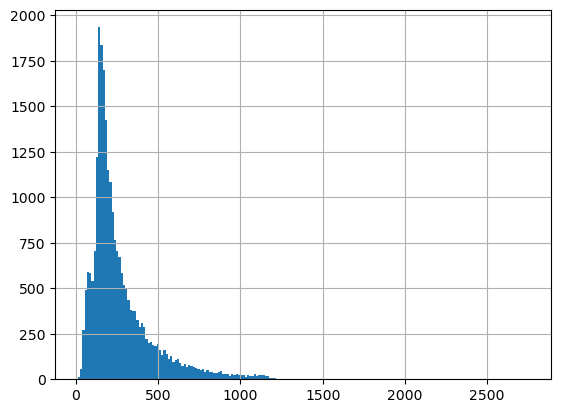

In [10]:
tab = pd.Series(len_list)
tab.hist(bins=200)

In [11]:
tab.max()

2752

In [12]:
print(tab.quantile(0.7))
print(tab.quantile(0.8))
print(tab.quantile(0.9))

292.0
374.0
530.0


In [13]:
def trans_string(list_result, index_dict, LEN_STRI):
    data = []
    for label, stri in list_result:
        stri = list(map(lambda x: index_dict.get(x, 1), stri[:LEN_STRI]))
        stri = stri + [0]*(LEN_STRI - len(stri)) if len(stri) < LEN_STRI else stri
        data.append((label, torch.LongTensor(stri))
                   )
    return data

In [14]:
LEN_STRI = 292
train_data = trans_string(train_list, index_word, LEN_STRI)
test_data = trans_string(val_list, index_word, LEN_STRI)

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=64, 
                                           shuffle=True)

In [16]:
for x in train_loader:
    break

In [17]:
for x in val_loader:
    break

## RNN

Для начала попробуем использовать рекурентные нейронные сети. На семинаре вы познакомились с GRU, вы можете также попробовать LSTM. Можно использовать для классификации как hidden_state, так и output последнего токена.

In [18]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, 
                           n_layers, bidirectional=bidirectional,
                           dropout=dropout)
        
        self.fc = nn.Sequential(nn.Flatten(), 
                                nn.Linear(hidden_dim, int(hidden_dim/2)),
                                nn.Linear(int(hidden_dim/2), output_dim)
                               )
        self.flat = nn.Flatten(0, 1)
        
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
       #packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        # cell arg for LSTM, remove for GRU
        output, (hidden, cell) = self.rnn(embedded)
        #unpack sequence
        #output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)  

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        #hidden = None  # YOUR CODE GOES HERE
                
        #hidden = [batch size, hid dim * num directions] or [batch_size, hid dim * num directions]
        #print(hidden.shape)
        hidden = hidden.permute(1, 0, 2)
        fc = self.fc(hidden)
            
        return fc

Поиграйтесь с гиперпараметрами

In [19]:
vocab_size = len(index_word) + 1
emb_dim = 100
hidden_dim = 256
output_dim = 2
n_layers = 1
bidirectional = False
dropout = 0.2
#PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
patience=3

In [20]:
model = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=0,
    pad_idx=0
)

In [21]:
model = model.to(device)

In [22]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

max_epochs = 20

Обучите сетку! Используйте любые вам удобные инструменты, Catalyst, PyTorch Lightning или свои велосипеды.

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    metric_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (y, x) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)  
            
            loss_value = loss(prediction, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            print(i_step,  end='\r')
        
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_metrics = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        metric_history.append(val_metrics)
        
        print(f'Average loss:{ave_loss}, f1: {val_metrics[2]}, \
              precision: {val_metrics[0]}, recall: {val_metrics[1]}')
        #print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, metric_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    predict_list = []
    y_list = []
    model.eval() # Evaluation mode
    for y, X in loader:
        X = X.to(device)
        y = y.to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        predict_list.extend(list(index.cpu()))
        y_list.extend(list(y.cpu()))
    
    precision = precision_score(y_list, predict_list)
    recall = recall_score(y_list, predict_list)
    f1 = f1_score(y_list, predict_list)
    
    return (precision, recall, f1)
    raise Exception("Not implemented")

In [24]:
opt = torch.optim.Adam(model.parameters())
#loss_func = nn.BCEWithLogitsLoss()
loss_func = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
max_epochs = 20

In [25]:
loss_history, train_history, metric_history \
= train_model(model, train_loader, val_loader, loss_func, opt, max_epochs)

Average loss:0.6950721144676208, f1: 0.6291436672397671,               precision: 0.5049629593763618, recall: 0.83432
Average loss:0.6935364603996277, f1: 0.6536593726789693,               precision: 0.5083533280014219, recall: 0.91528
Average loss:0.6803185939788818, f1: 0.2741708049782356,               precision: 0.5867226449750722, recall: 0.17888
Average loss:0.6625267267227173, f1: 0.2828210198334232,               precision: 0.5633802816901409, recall: 0.1888
Average loss:0.6196848154067993, f1: 0.6550549034456645,               precision: 0.5150460312371181, recall: 0.8996
Average loss:0.5505903959274292, f1: 0.38103213650162254,               precision: 0.5510142294883439, recall: 0.2912
Average loss:0.4012276828289032, f1: 0.7557287475115423,               precision: 0.803042578089837, recall: 0.71368
Average loss:0.2492179572582245, f1: 0.8046202998279676,               precision: 0.8244082591908679, recall: 0.78576
Average loss:0.14444269239902496, f1: 0.82164297610287,    

Посчитайте f1-score вашего классификатора на тестовом датасете.

**Ответ**:

## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень хороший фильм" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно. Давайте попробуем!

In [ ]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first тк мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

Вы можете использовать Conv2d с `in_channels=1, kernel_size=(kernel_sizes[0], emb_dim))` или Conv1d c `in_channels=emb_dim, kernel_size=kernel_size[0]`. Но хорошенько подумайте над shape в обоих случаях.

In [ ]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        dropout=0.5,
    ):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv_0 = None  # YOUR CODE GOES HERE
        
        self.conv_1 = None  # YOUR CODE GOES HERE
        
        self.conv_2 = None  # YOUR CODE GOES HERE
        
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        
        embedded = embedded  # may be reshape here
        
        conved_0 = F.relu(self.conv_0(embedded))  # may be reshape here
        conved_1 = F.relu(self.conv_1(embedded))  # may be reshape here
        conved_2 = F.relu(self.conv_2(embedded))  # may be reshape here
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return self.fc(cat)

In [ ]:
kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
out_channels=64
dropout = 0.5
dim = 300

model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, dropout=dropout)

In [ ]:
model.to(device)

In [ ]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
max_epochs = 30

Обучите!

In [ ]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        #YOUR CODE GOES HERE

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        # YOUR CODE GOES HERE
    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Посчитайте f1-score вашего классификатора.

**Ответ**:

## Интерпретируемость

Посмотрим, куда смотрит наша модель. Достаточно запустить код ниже.

In [ ]:
!pip install -q captum

In [ ]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)

In [ ]:
def forward_with_softmax(inp):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=5000, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [ ]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

Попробуйте добавить свои примеры!

In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

## Эмбеддинги слов

Вы ведь не забыли, как мы можем применить знания о word2vec и GloVe. Давайте попробуем!

In [ ]:
TEXT.build_vocab(trn, vectors=)# YOUR CODE GOES HERE
# подсказка: один из импортов пока не использовался, быть может он нужен в строке выше :)
LABEL.build_vocab(trn)

word_embeddings = TEXT.vocab.vectors

kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300

In [ ]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

device = "cuda" if torch.cuda.is_available() else "cpu"
        return self.fc(hidden)
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [ ]:
model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=64,
            kernel_sizes=kernel_sizes, dropout=dropout)

word_embeddings = TEXT.vocab.vectors

prev_shape = model.embedding.weight.shape

model.embedding.weight = # инициализируйте эмбэдинги

assert prev_shape == model.embedding.weight.shape
model.to(device)

opt = torch.optim.Adam(model.parameters())

Вы знаете, что делать.

In [ ]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        #YOUR CODE GOES HERE

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        # YOUR CODE GOES HERE
    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Посчитайте f1-score вашего классификатора.

**Ответ**:

Проверим насколько все хорошо!

In [ ]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)
vis_data_records_ig = []

interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)